# TODO:
+ Input dimensions (5x236) --> (5x229) ???
+ Expected doesn't match output layer dimensions. Add FLATTEN?
+ Epochs/Batch Size.. Choosing hyperparams???
+ Use Generator to optimize memory use?
+ Use pretty_midi to match expected 88 (refer to Sigtia)
  + Use subset of array, how to select midi_min, midi_max?

# Imports

In [1]:
import sys, os
import numpy as np
import pandas as pd
import madmom as mm
import librosa as lr
import pretty_midi as pm
import librosa.display as display
import IPython.display as ipd
import matplotlib.pyplot as plt
import json
import pickle

import keras
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, CSVLogger
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Activation, Reshape
from keras.layers import Conv2D, ZeroPadding2D, Dense
from keras.layers import Dropout, MaxPooling2D, Flatten
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
from keras.models import model_from_json


/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Constants

In [2]:
DATAPOINT = "../datasets/maps/CH/" + \
            "MAPS_ISOL_CH0.1_F_SptkBGAm.wav"
MIDI_DATAPOINT = "../datasets/maps/CH/" + \
        "MAPS_ISOL_CH0.1_F_SptkBGAm.mid"
WINDOW_SIZE = 5
MIN_MIDI = 21
MAX_MIDI = 108

# Preprocess

#### Generate spectrogram:

In [42]:
logSpect = mm.audio.spectrogram.LogarithmicFilteredSpectrogram(
    DATAPOINT,
    num_bands=48,
    num_channels=1,
    sr=44100,
    unique_filters=True,
    norm_filters=True,
    frame_size=4096,
    fft_size=4096,
    fmin=27.5,
    fmax=8000.0,
    fref=440.0,
    circular_shift=False,
    fps=31.25,
    norm=True)

In [43]:
logSpect = np.array(logSpect)
logSpect.shape

(683, 229)

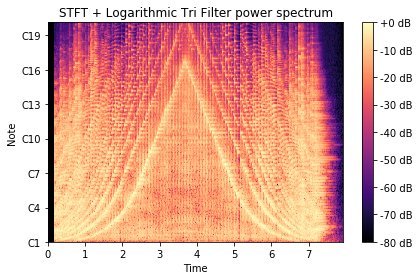

In [44]:
lr.display.specshow(
    lr.amplitude_to_db(logSpect, ref=np.max).T, 
    sr=44100,
    x_axis='time',
    y_axis='cqt_note')
plt.colorbar(format='%+2.0f dB')
plt.title('STFT + Logarithmic Tri Filter power spectrum')
plt.tight_layout()

#### Normalize, Rescale:

In [6]:
logSpect = np.nan_to_num(logSpect)

In [7]:
logSpect = np.abs(logSpect)

In [8]:
logSpect /= np.max(logSpect, axis=0)

In [9]:
logSpect.shape

(683, 229)

#### Generate ground truth:

In [10]:
times = lr.frames_to_time(
    np.arange(logSpect.shape[0]),
    sr=44100,
    hop_length=441.0)

In [11]:
midi = pm.PrettyMIDI(MIDI_DATAPOINT)

In [12]:
expected = midi.get_piano_roll(fs=44100, times=times)[MIN_MIDI:MAX_MIDI+1].T

In [13]:
expected[expected > 0] = 1

#### Generate windows:

Add zero padding:

In [32]:
min_db = np.min(logSpect)
min_db

0.0

In [46]:
logSpect = np.pad(
    logSpect, 
    ((WINDOW_SIZE//2, WINDOW_SIZE//2), (0,0)),
    'constant',
    constant_values=min_db)

In [15]:
windows = []

for i in range(logSpect.shape[0] - WINDOW_SIZE + 1):
    w = logSpect[i:i+WINDOW_SIZE,:]
    windows.append(w)

cleanDatapoints = np.array(windows)

Sanity check input to output shapes:

In [16]:
print cleanDatapoints.shape
print expected.shape

(683, 5, 229)
(683, 88)


In [17]:
logSpect.shape

(687, 229)

Check size of saved training and expected arrays:

In [18]:
# np.save("cleanDatapoints", cleanDatapoints)
# np.save("groundTruths", expected)

# Compile and Train Model

In [19]:
inputShape = cleanDatapoints[0].shape
inputShapeDimensions = (WINDOW_SIZE, logSpect.shape[1], 1)

In [20]:
print inputShape
print inputShapeDimensions

(5, 229)
(5, 229, 1)


In [51]:
# ORIGINAL (from filip)
# # Layers
# input = Input(inputShape)
# reshape = Reshape(inputShapeDimensions)(input)
# conv1 = Conv2D(32, (3, 3), activation='relu')(reshape)
# zeroPad = ZeroPadding2D(padding=(WINDOW_SIZE//2, WINDOW_SIZE//2))(conv1)

# # Add linear conv layer
# conv2 = Conv2D(32, (3, 3))(zeroPad)

# # Apply batch norm
# batchNorm = BatchNormalization()(conv2)

# # Then activation layer
# nonlinAct = Activation('relu')(batchNorm)

# maxPool1 = MaxPooling2D(pool_size=(1, 2))(nonlinAct)
# dropOut1 = Dropout(0.25)(maxPool1)
# conv3 = Conv2D(64, (3, 3), activation='relu')(dropOut1)
# maxPool2 = MaxPooling2D(pool_size=(1, 2))(conv3)
# flatten = Flatten()(maxPool2)
# dropOut2 = Dropout(0.25)(flatten)
# dense1 = Dense(512, activation='relu')(dropOut2)
# dropOut3 = Dropout(0.5)(dense1)
# output = Dense(88, activation='sigmoid')(dropOut3)

# NEW (rainer)
input = Input(inputShape)
reshape = Reshape((5, 229, 1))(input)

conv_1 = Conv2D(32, (3, 3), activation='relu')(reshape)
zero_pad = ZeroPadding2D(padding=(5 // 2, 5 // 2))(conv_1)
batch_norm_1 = BatchNormalization()(zero_pad)
conv_2 = Conv2D(32, (3, 3), activation='relu')(batch_norm_1)
batch_norm_2 = BatchNormalization()(conv_2)
max_pool_1 = MaxPooling2D(pool_size=(1, 2))(batch_norm_2)
dropout_1 = Dropout(0.25)(max_pool_1)

conv_3 = Conv2D(64, (3, 3), activation='relu')(dropout_1)
batch_norm_3 = BatchNormalization()(conv_3)
max_pool_2 = MaxPooling2D(pool_size=(1, 2))(batch_norm_3)
flatten = Flatten()(max_pool_2)
dropout_2 = Dropout(0.25)(flatten)

dense_1 = Dense(512, activation='relu')(dropout_2)
batch_norm_4 = BatchNormalization()(dense_1)
dropout_3 = Dropout(0.5)(batch_norm_4)

output = Dense(88, activation='sigmoid')(dropout_3)

# Result
baseline = Model(inputs=input, outputs=output)

In [52]:
baseline.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 5, 229)            0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 5, 229, 1)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 3, 227, 32)        320       
_________________________________________________________________
zero_padding2d_6 (ZeroPaddin (None, 7, 231, 32)        0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 7, 231, 32)        128       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 5, 229, 32)        9248      
_________________________________________________________________
batch_normalization_22 (Batc (None, 5, 229, 32)        128       
__________

In [ ]:
# TODO: lr hardcoded, add lr halving after epochs
baseline.compile(
    loss='binary_crossentropy',
    optimizer=SGD(lr=0.1, momentum=0.9),
    metrics=['accuracy', 'mse', 'mae']
)

#### Train:

In [ ]:
class HalfDecay(Callback):
    '''
        decay = decay value to subtract each epoch
    '''
    def __init__(self, initial_lr,period):
        super(HalfDecay, self).__init__()
        self.init_lr = initial_lr
        self.period = period

    def on_epoch_begin(self, epoch, logs={}):
        factor = epoch // self.period
        lr  = self.init_lr / (2**factor)
        print("hd: learning rate is now "+str(lr))
        K.set_value(self.model.optimizer.lr, lr)
        


In [ ]:
decay = HalfDecay(0.1, 5)
checkpoint = ModelCheckpoint("baseline_checkpoint.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# earlyStop = EarlyStopping(patience=5,monitor='val_loss', verbose=1, mode='min')

## Test Data Geneartor

In [ ]:
def read_mm(data_dir, type, ID):
    NOTE_RANGE = 88
    WINDOW_SIZE = 5
    N_BINS = 229
    
    input_path = os.path.join(data_dir, type, ID)
# RE-WORK THIS (expect shouldn't be hardcoded)
    output_path = os.path.join(data_dir, 'expect', ID)  
    
    mm_input = np.memmap(input_path, mode='r')
    mm_output = np.memmap(output_path, mode='r')
    input = np.reshape(mm_input, (-1, WINDOW_SIZE, N_BINS))
    output = np.reshape(mm_output, (-1, NOTE_RANGE))
                        
    return input, output
    

class DataGenerator(keras.utils.Sequence):
    def __init__(self, model_data_dir, data_type, list_IDs, batch_size=32, shuffle=True):
        self.model_data_dir = model_data_dir # Denotes specific train/val/test for a given model
        self.data_type = data_type           # Denotes train, val, or test 
        self.list_IDs = list_IDs
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size datapoints'
        # Init
        X, y = [], []
        
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            input, output = read_mm(self.model_data_dir, self.data_type, ID)
            
            X.append(input)
            y.append(output)
            
        # Flatten 
        X = np.concatenate(X)
        y = np.concatenate(y)

        return X, y
    
    def __len__(self):
        'Denotes # of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    
    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size : (index+1)*self.batch_size]
        
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[i] for i in indexes]
        
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        
        return X, y

In [ ]:
ID1 = 'MAPS_ISOL_NO_M_S0_M58_SptkBGAm.dat'
ID2 = 'MAPS_ISOL_NO_P_S0_M52_SptkBGAm.dat'

TRAIN_DIR = '../splits/config-2_logfilt_baseline/train/'
TEST_DIR = '../splits/config-2_logfilt_baseline/test/'
EXPECT_DIR = '../splits/config-2_logfilt_baseline/expect/'
ROOT_DIR = '../splits/config-2_logfilt_baseline/'
a, b = read_mm(ROOT_DIR, 'test', ID1)
c, d = read_mm(ROOT_DIR, 'test', ID2)

In [ ]:
print a.shape
print c.shape

X = []
X.append(a)
X.append(c)

X = np.concatenate(X)
print X.shape

## Train Model

In [ ]:
partition = {}
partition['train'] = []
partition['val'] = []

test_datapoints = os.listdir(TRAIN_DIR)
N_DATAPOINTS = len(test_datapoints)
print N_DATAPOINTS
test_datapoints[:10]


In [ ]:
np.random.shuffle(test_datapoints)
test_datapoints[:10]

In [ ]:
n_val = int(0.16 * N_DATAPOINTS)
split_index = N_DATAPOINTS - n_val
split_index
partition['train'], partition['val'] = test_datapoints[:split_index], test_datapoints[split_index:]

train_gen = DataGenerator(ROOT_DIR, 'train', partition['train'])
val_gen = DataGenerator(ROOT_DIR, 'train', partition['val'])

In [ ]:
print len(partition['train'])
print len(partition['val'])

In [ ]:
# # Really slow locally =(
# history = baseline.fit_generator(
#     generator=train_gen,
#     validation_data=val_gen,
#     epochs=1,
#     use_multiprocessing=True,
# #     workers=3,
#     verbose=1,
#     callbacks=[decay, checkpoint])

In [ ]:
history = baseline.fit(
    x=cleanDatapoints, 
    y=expected,
    callbacks=[decay],
    batch_size=100,
    epochs=150,
    verbose=1,
    validation_split=0.33)

In [ ]:
# baseline.fit?
history.history.keys()

In [ ]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train_mse', 'val_mse'])
plt.title('Baseline_test MSE')
plt.savefig('../results/baseline_test/baseline_test_mse.png')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.title('Baseline_test')
plt.savefig('../results/baseline_test/baseline_test_valloss.png')
plt.show()

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'])
plt.title('Baseline_test')
# plt.savefig('../results/baseline_test/baseline_test_acc.png')
plt.show()

Save model architecture and weights:

In [ ]:
baselineJson = baseline.to_json()
with open("../results/baseline_test/baseline_test.json", "w") as jsonFile:
    jsonFile.write(baselineJson)
with open("../results/baseline_test/baseline_test_hist", 'wb') as file:
    pickle.dump(history.history, file)
baseline.save_weights("../results/baseline_test/baseline_test.h5")

In [ ]:
saved_hist = pickle.load(open("../results/baseline_test/baseline_test_hist", "rb"))
saved_hist.keys()

## Evaluate

https://craffel.github.io/mir_eval/#module-mir_eval.transcription

In [ ]:
jsonFile = open("../results/baseline_test/baseline_test.json", "r")
loaded_baseline_json = jsonFile.read()
jsonFile.close()
loadedBaseline = model_from_json(loaded_baseline_json)
loadedBaseline.load_weights("../results/baseline_test/baseline_test.h5")
loadedBaseline.compile(
    loss='binary_crossentropy',
    optimizer=SGD(lr=0.1,momentum=0.9),
    metrics=['accuracy', 'mse', 'mae'])

Read test data:

In [ ]:
# X, y = [], []
# list_IDs = os.listdir(TEST_DIR)
# for i, ID in enumerate(list_IDs):
#     print "opened a file"
#     input, output = read_mm(ROOT_DIR, 'test', ID)
#     X.append(input)
#     y.append(output)
            
# # Flatten 
# X = np.concatenate(X)
# y = np.concatenate(y)

In [ ]:
results = loadedBaseline.evaluate(
                x=cleanDatapoints,
                y=expected,
                verbose=1)

In [ ]:
loadedBaseline.metrics_names

In [ ]:
results